In [1]:
import pickle
from misc import *
import SYCLOP_env as syc
from RL_brain_b import DeepQNetwork


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import cv2

In [4]:
from mnist import MNIST

mnist = MNIST('/home/bnapp/datasets/mnist/')
images, labels = mnist.load_training()

# # some_mnist =[ cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256), interpolation=cv2.INTER_AREA) for uu in images[:20]]           
# some_mnistSM =[ cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256)) for uu in images[:20]]           
# # some_mnist0p5 =[ 0.5*cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256), interpolation=cv2.INTER_AREA) for uu in images[:20]]    
# # some_mnistSM0p5 =[ 0.5*cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256)) for uu in images[:20]]           


In [5]:
    hp = HP()
    hp.mem_depth=1
    hp.logmode = False
#     recorder = Recorder(n=4)

    #load Liron's dataset
    images = read_images_from_path('../video_datasets/liron_images/*.jpg')
    images = [np.sum(1.0*uu, axis=2) for uu in images]
    images = [cv2.resize(uu, dsize=(256, 256-64), interpolation=cv2.INTER_AREA) for uu in images]

#     images += read_images_from_path('/home/bnapp/arivkindNet/video_datasets/stills_from_videos/some100img_from20bn/*',max_image=10)
#     images = some_mnistSM #+some_mnist + some_mnist0p5 + +some_mnistSM0p5
#     images = images = prep_mnist_sparse_images(10,images_per_scene=20)
#     images = [np.sum(1.0*uu, axis=2) for uu in images]
#     images = [cv2.resize(uu, dsize=(256, 256-64), interpolation=cv2.INTER_AREA) for uu in images]
#     import pickle
#     with open('../video_datasets/liron_images/shuffled_images.pkl','rb') as f:
#         uu = pickle.load(f)
#     images +=uu
    scene = syc.Scene(frame_list=images)
    sensor = syc.Sensor()
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

    reward = syc.Rewards()
    observation_size = 256*4
    RL = DeepQNetwork(len(agent.hp.action_space), observation_size*hp.mem_depth,#sensor.frame_size+2,
                      reward_decay=0.99,
                      e_greedy=1-1e-9,
                      e_greedy0=1-1e-9,
                      replace_target_iter=10,
                      memory_size=100000,
                      e_greedy_increment=0.0001,
                      learning_rate=0.0025,
                      double_q=False,
                      dqn_mode=True,
                      state_table=np.zeros([1,observation_size*hp.mem_depth]),
                      soft_q_type='boltzmann',
                      beta=1.0
                      )




debug n_features: 1024
debug: (?, 1024)
debug: (?, 400)
debug: (?, 200)
debug: (?, 200)
debug: (?, 200)
debug n_features: 1024
debug: (?, 1024)
debug: (?, 400)
debug: (?, 200)
debug: (?, 200)
debug: (?, 200)


In [42]:
RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1575974279_0/tempX_1.nwk') 
# RL.dqn.load_nwk_param('saved_runs/run_syclop_generic1.py_noname_1575974279_0/best_liron.nwk') 

In [77]:

def local_observer(sensor,agent,mask=1.0):
    if hp.logmode:
        normfactor=1.0
    else:
        normfactor = 1.0/256.0
    # return np.concatenate([1.0/65000*(sensor.dvs_view.reshape([-1]))])
    # return 1.0/65000*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
    #        relu_up_and_down(sensor.dvs_view, downsample_fun=lambda x: cv2.resize(x, dsize=(16, 16), interpolation=cv2.INTER_AREA))])
    return normfactor*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
            relu_up_and_down(cv2.resize(1.0*mask*sensor.dvs_view, dsize=(16, 16), interpolation=cv2.INTER_AREA))])

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
hp.fading_mem = 0.5

In [95]:
RL.beta=0.1

In [121]:
rms_speeds=[]
for kk in range(8):
    mask=border_mask(np.shape(sensor.dvs_view),kk)

    recorders=[]
    for image_num,image in enumerate(images):
        recorder = Recorder(n=4)
        step = 0
        episode = 0
        observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
        observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
        scene.current_frame = image_num
        scene.image = scene.frame_list[scene.current_frame]

        agent.reset()
        agent.q_ana[1]=256./2.-32
        agent.q_ana[0]=192./2-32
        agent.q = np.int32(np.floor(agent.q_ana))

        sensor.reset()
        sensor.update(scene, agent)
        sensor.update(scene, agent)
        for step_prime in range(800):
            action = RL.choose_action(observation.reshape([-1]))
            reward.update_rewards(sensor = sensor, agent = agent)
            recorder.record([agent.q_ana[0],agent.q_ana[1],reward.reward,RL.epsilon])
            agent.act(action)
            sensor.update(scene,agent)
            observation *= hp.fading_mem
            observation += local_observer(sensor, agent,mask=mask)  # todo: generalize
            if step%1000 ==0:
                print(episode,step)
    #                 print('frame:', scene.current_frame)
            step += 1
        recorders.append(recorder)

    rms_speeds.append([rms_speed_fun([uu[600:] for uu in recorder.records[:2]]) for recorder in recorders])
    print(rms_speeds)


0 0
0 0
0 0
0 0
0 0
[[1.2558190103807418, 1.2558190103807418, 1.2558190103807418, 0.8681986202598491, 0.8681986202598491]]
0 0
0 0
0 0
0 0
0 0
[[1.2558190103807418, 1.2558190103807418, 1.2558190103807418, 0.8681986202598491, 0.8681986202598491], [1.2641162722426857, 1.2558190103807418, 1.2558190103807418, 0.8681986202598491, 1.2641162722426857]]
0 0
0 0
0 0
0 0
0 0
[[1.2558190103807418, 1.2558190103807418, 1.2558190103807418, 0.8681986202598491, 0.8681986202598491], [1.2641162722426857, 1.2558190103807418, 1.2558190103807418, 0.8681986202598491, 1.2641162722426857], [1.2641162722426857, 1.2558190103807418, 1.3299600435089658, 0.8667431311889617, 1.2558190103807418]]
0 0
0 0
0 0
0 0
0 0
[[1.2558190103807418, 1.2558190103807418, 1.2558190103807418, 0.8681986202598491, 0.8681986202598491], [1.2641162722426857, 1.2558190103807418, 1.2558190103807418, 0.8681986202598491, 1.2641162722426857], [1.2641162722426857, 1.2558190103807418, 1.3299600435089658, 0.8667431311889617, 1.2558190103807418]

<IPython.core.display.Javascript object>


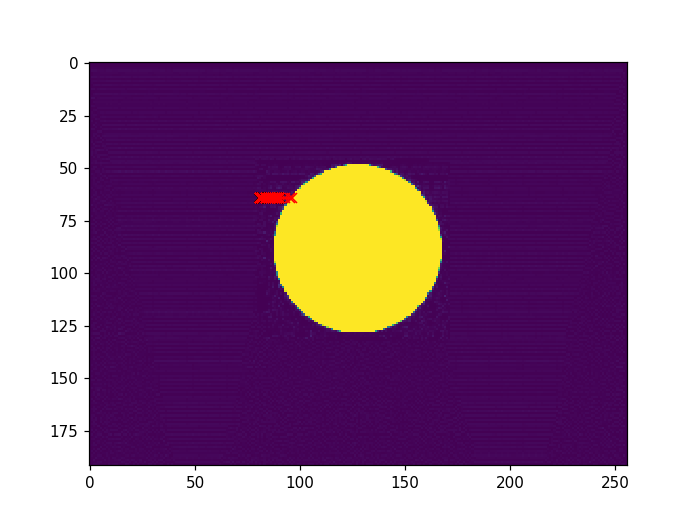

<IPython.core.display.Javascript object>


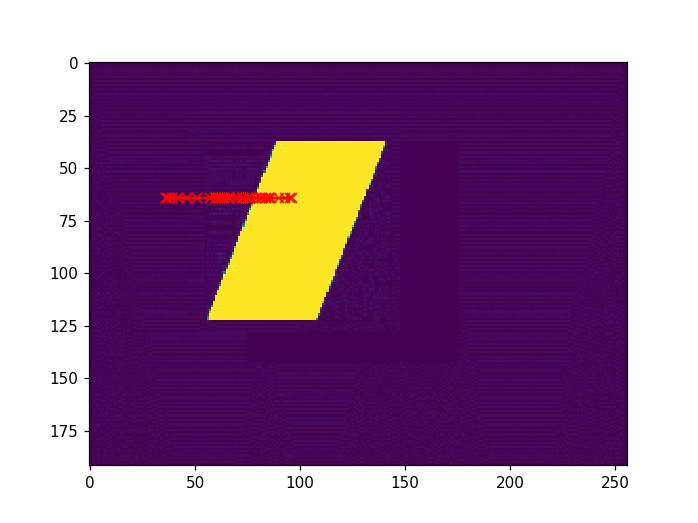

<IPython.core.display.Javascript object>


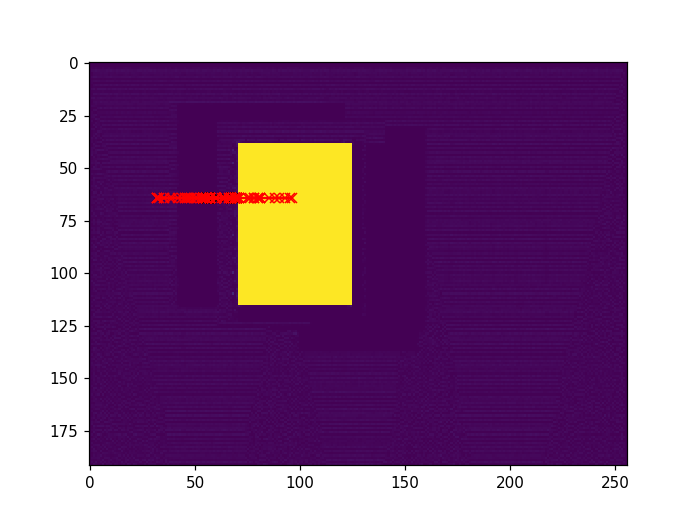

<IPython.core.display.Javascript object>


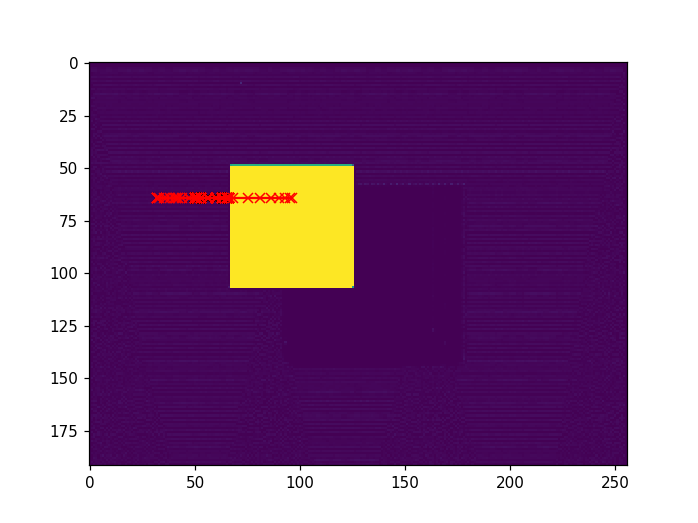

<IPython.core.display.Javascript object>


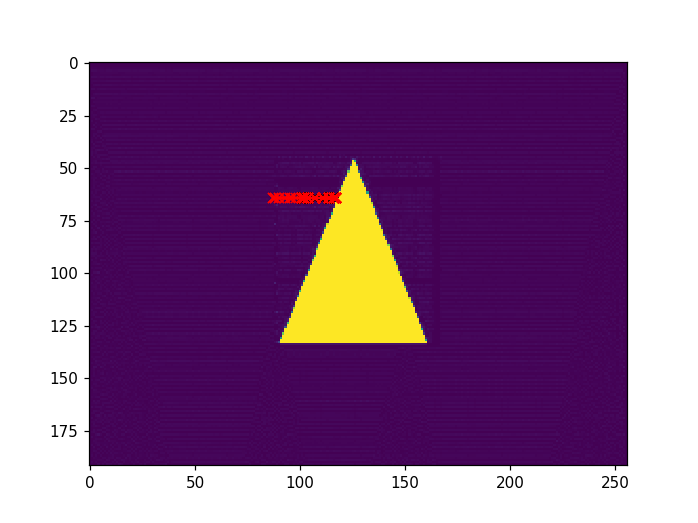

In [100]:
for image,recorder in zip(images,recorders):
    plt.figure()
    plt.imshow(image,vmax=256,vmin=0)
    plt.plot(32+np.array(recorder.records[0]),image.shape[0]-32-np.array(recorder.records[1]),'r-x')



<IPython.core.display.Javascript object>


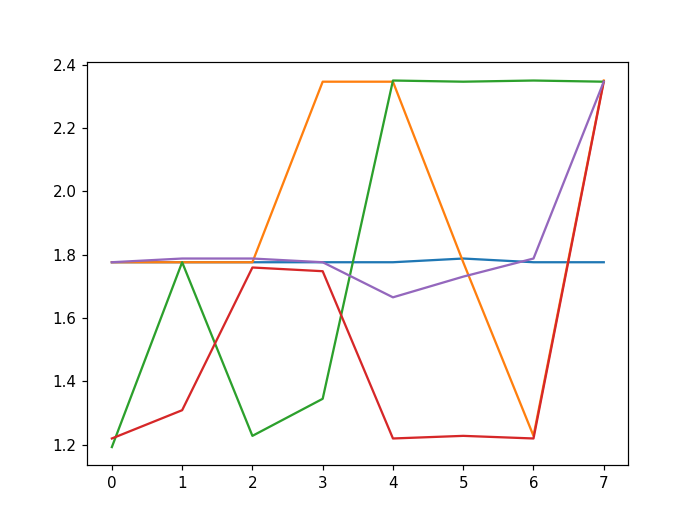

In [101]:
plt.figure()
plt.plot(rms_speeds)

<IPython.core.display.Javascript object>


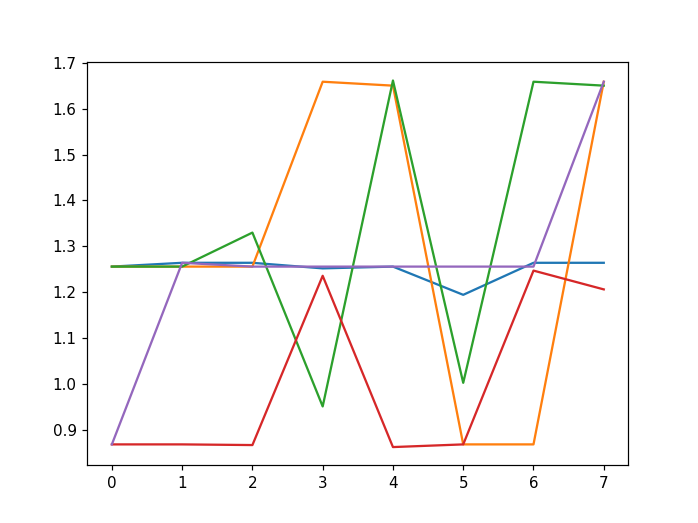

In [122]:
plt.figure()
plt.plot(rms_speeds)

<IPython.core.display.Javascript object>


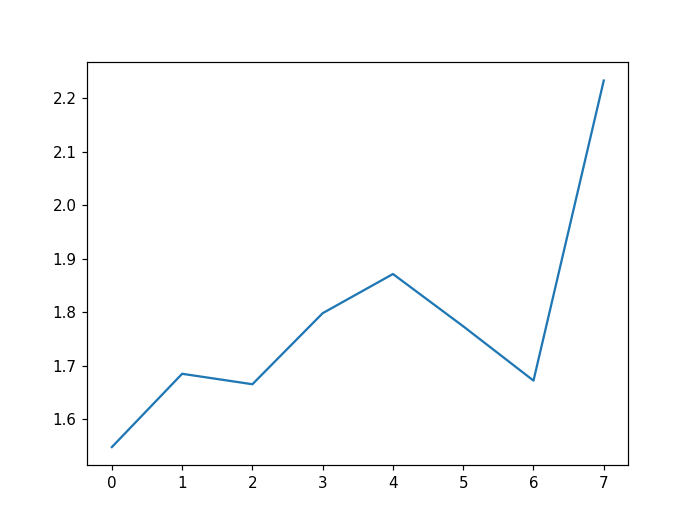

In [102]:
plt.figure()
plt.plot(np.mean(rms_speeds,axis=1))

<IPython.core.display.Javascript object>


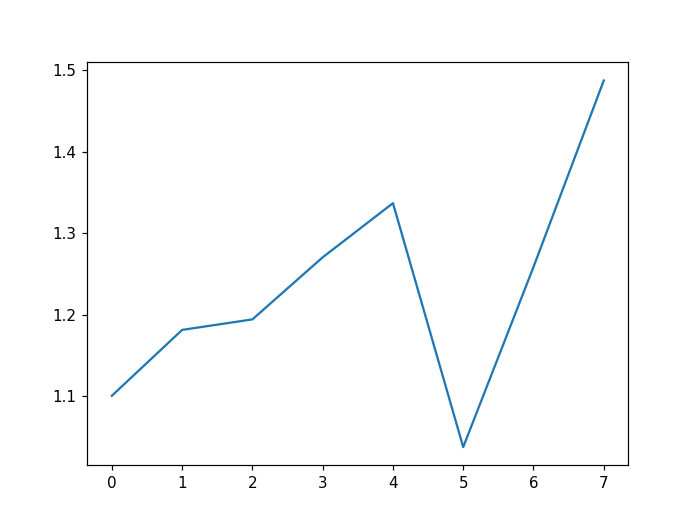

In [123]:
plt.figure()
plt.plot(np.mean(rms_speeds,axis=1))

<IPython.core.display.Javascript object>


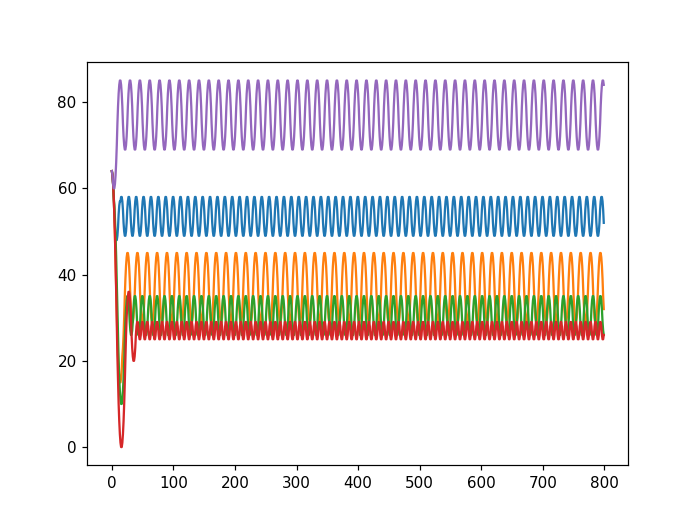

In [89]:
plt.figure()
for image,recorder in zip(images,recorders):
    plt.plot(np.array(recorder.records[0]))

In [90]:
rms_speeds.append([np.std(recorder.records[0][600:]) for recorder in recorders])
print(rms_speeds)

[3.388746080779733, 5.956299186575503, 3.410043987986079, 1.5811388300841898, 5.956299186575503]


In [103]:
recorder.records[0:2]

[[64.0,
  63.0,
  61.0,
  58.0,
  56.0,
  55.0,
  55.0,
  56.0,
  58.0,
  61.0,
  63.0,
  66.0,
  70.0,
  75.0,
  79.0,
  82.0,
  84.0,
  85.0,
  85.0,
  84.0,
  82.0,
  79.0,
  75.0,
  72.0,
  70.0,
  69.0,
  69.0,
  70.0,
  72.0,
  75.0,
  79.0,
  82.0,
  84.0,
  85.0,
  85.0,
  84.0,
  82.0,
  79.0,
  75.0,
  72.0,
  70.0,
  69.0,
  69.0,
  70.0,
  72.0,
  75.0,
  79.0,
  82.0,
  84.0,
  85.0,
  85.0,
  84.0,
  82.0,
  79.0,
  75.0,
  72.0,
  70.0,
  69.0,
  69.0,
  70.0,
  72.0,
  75.0,
  79.0,
  82.0,
  84.0,
  85.0,
  85.0,
  84.0,
  82.0,
  79.0,
  75.0,
  72.0,
  70.0,
  69.0,
  69.0,
  70.0,
  72.0,
  75.0,
  79.0,
  82.0,
  84.0,
  85.0,
  85.0,
  84.0,
  82.0,
  79.0,
  75.0,
  72.0,
  70.0,
  69.0,
  69.0,
  70.0,
  72.0,
  75.0,
  79.0,
  82.0,
  84.0,
  85.0,
  85.0,
  84.0,
  82.0,
  79.0,
  75.0,
  72.0,
  70.0,
  69.0,
  69.0,
  70.0,
  72.0,
  75.0,
  79.0,
  82.0,
  84.0,
  85.0,
  85.0,
  84.0,
  82.0,
  79.0,
  75.0,
  72.0,
  70.0,
  69.0,
  69.0,
  70.0,
  72.0,


In [73]:
trajectories=[]
for image,recorder in zip(images,recorders):
    trajectories.append([32+np.array(recorder.records[0]),image.shape[0]-32-np.array(recorder.records[1])])

In [ ]:
for image,trajectory in zip(images,trajectories):
    plt.figure()
    plt.imshow(image,vmax=256,vmin=0)
    plt.plot(trajectory[0],trajectory[1],'r-x')

In [ ]:
with open('image_and_trajectory_examples.pkl','wb') as f:
    pickle.dump([images,trajectories],f)

In [52]:
# RL.dqn.save_nwk_param('saved_runs/run_syclop_generic1.py_noname_1575974279_0/very_oscillatory1.nwk')

In [ ]:
# import pickle
# with open('../video_datasets/liron_images/shuffled_images.pkl','rb') as f:
#     uu = pickle.load(f)

In [51]:
RL.beta

0.1

In [ ]:
run_dir ='saved_runs/run_syclop_generic3.py_noname_156440904369715104/'

In [ ]:
with open(run_dir+'/hp.pkl','rb') as f:
          this_hp = pickle.load(f)

In [ ]:
this_hp.RL.gamma

In [ ]:
this_hp.fading_mem

In [ ]:
this_hp.reward.relative_weights

In [59]:
mask=np.zeros([10,10])
mask[0:-1,1:None]=1
print(mask)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [62]:
def border_mask(shape,k):
    k2 = None if k==0 else -k 
    mask=np.zeros(shape)
    mask[k:k2,k:k2]=1
    return mask
    

In [119]:
def rms_speed_fun(rec):
    vv=np.diff(rec,axis=1)
    vv=vv-np.mean(vv,axis=1)[:,np.newaxis]
    return np.sqrt(np.mean(vv**2))

In [108]:
border_mask([11,11],0)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [109]:
np.diff(recorder.records[:2],axis=1)

array([[-1., -2., -3., ...,  3.,  4.,  3.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [120]:
rms_speed_fun(recorder.records[:2])

1.6637929007898327